# Good model on mnist digits

In [112]:
from keras.utils import to_categorical
from keras.datasets import cifar10, mnist
from keras.models import Sequential
from keras.applications import resnet50
from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.layers import (Activation,
                          Conv2D, Dense,
                          Dropout, Flatten,
                          MaxPool2D)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

from plots import plot_learning_curves
from utils import partition_classes

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def norm(arr):
    return arr / 255.0

def denorm(arr):
    return (arr * 255).astype(int)

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train_labels), (x_test, y_test_labels) = mnist.load_data()
x_train, x_test = x_train.reshape(60000, 28, 28, 1), x_test.reshape(10000, 28, 28, 1)
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

In [113]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

In [114]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_resnet50.hdf5', verbose=1, save_best_only=True)

In [6]:
EPOCHS = 1
history = model.fit(norm(x_train), y_train, validation_split=.2,
                    epochs=EPOCHS, callbacks=[checkpoint], batch_size=64)

Train on 48000 samples, validate on 12000 samples
Epoch 1/1
 3456/48000 [=>............................] - ETA: 3:06 - loss: 0.8686 - acc: 0.7214

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ryan/repos/deep_learning_mabs/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-27f2c11aa7c2>", line 3, in <module>
    epochs=EPOCHS, callbacks=[checkpoint], batch_size=64)
  File "/Users/ryan/repos/deep_learning_mabs/.env/lib/python3.6/site-packages/keras/models.py", line 963, in fit
    validation_steps=validation_steps)
  File "/Users/ryan/repos/deep_learning_mabs/.env/lib/python3.6/site-packages/keras/engine/training.py", line 1712, in fit
    validation_steps=validation_steps)
  File "/Users/ryan/repos/deep_learning_mabs/.env/lib/python3.6/site-packages/keras/engine/training.py", line 1235, in _fit_loop
    outs = f(ins_batch)
  File "/Users/ryan/repos/deep_learning_mabs/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2475, in __call__
    **self.session_kwargs)
  File "/Users/ryan/rep

KeyboardInterrupt: 

In [8]:
model.load_weights(checkpoint.filepath)

In [9]:
model.evaluate(norm(x_test), y_test)

10000/10000 [==============================] - 11s 1ms/step


[0.047730291922064495, 0.9857]

# let's use MABS

first need to cluster the images while keeping class balance

In [54]:
x_train.shape[0]

60000

In [68]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
np.random.seed(42)
n_digits = len(np.unique(y_train_labels))
labels = y_train_labels



In [107]:
def bench_k_means(estimator, name, data, labels, sample_size=300, random=True):
    if random:
        indeces = np.random.choice(np.arange(x_train.shape[0]), size=sample_size)
        labels = labels[indeces]
        data = data[indeces]
    if not random:
        labels = labels[:sample_size]
        data = data[:sample_size]
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
    return estimator

In [138]:
kmeans = bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=100),
              name='k-means++', data=x_train.reshape(60000, -1),
              labels=y_train_labels, sample_size=3000)

k-means++	26.34s	7647017999	0.499	0.508	0.504	0.375	0.496	0.064


In [139]:
kmeans.predict(x_train[10].reshape(1, -1))

array([9], dtype=int32)

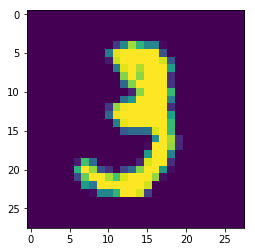

In [140]:
plt.imshow(x_train[10].reshape(28, 28))